In [2]:
import pandas as pd
import numpy as np

In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv('GSPC_2015_2020.csv')

In [83]:
spx = df.set_index('Date').pct_change()['Adj Close'].fillna(0)
spx.describe(), spx.isnull().sum()

(count    1259.000000
 mean        0.000538
 std         0.012115
 min        -0.119841
 25%        -0.002932
 50%         0.000648
 75%         0.005094
 max         0.093828
 Name: Adj Close, dtype: float64,
 0)

In [261]:
data_gen_df.loc[:'2019-08-20']

Date
2015-08-24   -0.044432
2015-08-25   -1.160540
2015-08-26    3.177429
2015-08-27    1.961108
2015-08-28    0.005813
                ...   
2019-08-14   -2.462261
2019-08-15    0.158969
2019-08-16    1.146303
2019-08-19    0.954788
2019-08-20   -0.697715
Name: Adj Close, Length: 1005, dtype: float64

In [266]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen_df = (spx.loc[:'2019-08-20'] - spx.loc[:'2019-08-20'].mean()) / spx.loc[:'2019-08-20'].std()
test_gen_df = (spx.loc['2019-08-20':] - spx.loc[:'2019-08-20'].mean()) / spx.loc[:'2019-08-20'].std()
train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=30)
test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=30)
train_data_gen[0][0].shape

(128, 30)

In [230]:
# https://github.com/usernaamee/keras-wavenet/blob/master/simple-generative-model.py

In [231]:
from tensorflow.keras.layers import Convolution1D, Convolution2D, Flatten, Dense, \
    Input, Lambda, Activation, BatchNormalization
from tensorflow import keras
import tensorflow

def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None):
    def f(input_):
        residual = input_
        tanh_out = Convolution1D(filters, kernel_size,
                                       dilation_rate=dilation_rate,
                                       padding='same',
                                       activation='tanh')(input_)
        sigmoid_out = Convolution1D(filters, kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding='same',
                                          activation='sigmoid')(input_)
        merged = keras.layers.Multiply()([tanh_out, sigmoid_out])
        skip_out = Convolution1D(1, 1, activation=activation, padding='same')(merged)
        out = keras.layers.Add()([skip_out, residual])
#         return out, skip_out
        return skip_out
    return f

In [279]:
def evaluate_model(model):
    total_mae = mean_absolute_error(train_gen_df[30:], np.zeros_like(train_gen_df[30:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[30:]) 
    print('train', model_mae, total_mae, model_mae/total_mae)
    total_mae = mean_absolute_error(test_gen_df[30:], np.zeros_like(test_gen_df[30:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[30:]) 
    print('test', model_mae, total_mae, model_mae/total_mae)

In [ ]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
# x = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
# x = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
# x = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
# x = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=300, validation_data=test_data_gen)
hist

In [ ]:
# x = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
# x = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
# x = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
# x = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)

In [ ]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=300, validation_data=test_data_gen)
hist

Epoch 1/300
8/8 [==============================] - 1s 130ms/step - loss: 1.1940 - val_loss: 1.9721
Epoch 2/300
8/8 [==============================] - 0s 50ms/step - loss: 1.0646 - val_loss: 1.8476
Epoch 3/300
8/8 [==============================] - 0s 45ms/step - loss: 0.9595 - val_loss: 1.7551
Epoch 4/300
8/8 [==============================] - 0s 46ms/step - loss: 0.8772 - val_loss: 1.6872
Epoch 5/300
8/8 [==============================] - 0s 45ms/step - loss: 0.8169 - val_loss: 1.6427
Epoch 6/300
8/8 [==============================] - 0s 47ms/step - loss: 0.7728 - val_loss: 1.6014
Epoch 7/300
8/8 [==============================] - 0s 47ms/step - loss: 0.7395 - val_loss: 1.5715
Epoch 8/300
8/8 [==============================] - 0s 48ms/step - loss: 0.7161 - val_loss: 1.5468
Epoch 9/300
8/8 [==============================] - 0s 48ms/step - loss: 0.7011 - val_loss: 1.5269
Epoch 10/300
8/8 [==============================] - 0s 46ms/step - loss: 0.6921 - val_loss: 1.5670
Epoch 11/300
8/8 [

Epoch 84/300
8/8 [==============================] - 0s 56ms/step - loss: 0.3339 - val_loss: 1.7670
Epoch 85/300
8/8 [==============================] - 0s 48ms/step - loss: 0.3440 - val_loss: 1.7889
Epoch 86/300
8/8 [==============================] - 1s 64ms/step - loss: 0.3336 - val_loss: 1.8215
Epoch 87/300
8/8 [==============================] - 0s 54ms/step - loss: 0.3560 - val_loss: 1.7688
Epoch 88/300
8/8 [==============================] - 0s 52ms/step - loss: 0.3343 - val_loss: 1.8005
Epoch 89/300
8/8 [==============================] - 0s 45ms/step - loss: 0.3207 - val_loss: 1.7826
Epoch 90/300
8/8 [==============================] - 0s 50ms/step - loss: 0.3178 - val_loss: 1.8186
Epoch 91/300
8/8 [==============================] - 0s 48ms/step - loss: 0.3145 - val_loss: 1.7793
Epoch 92/300
8/8 [==============================] - 0s 55ms/step - loss: 0.3220 - val_loss: 1.8250
Epoch 93/300
8/8 [==============================] - 0s 47ms/step - loss: 0.3131 - val_loss: 1.7495
Epoch 94/3

In [280]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=300, validation_data=test_data_gen)
evaluate_model(model)
hist

train 0.6560850523329298 0.6542154487460116 1.002857779635901
test 1.5009530248193332 1.4872528866796857 1.0092117072102198


In [281]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=300, validation_data=test_data_gen)
evaluate_model(model)
hist

Epoch 1/300
8/8 [==============================] - 1s 114ms/step - loss: 0.6579 - val_loss: 1.4825
Epoch 2/300
8/8 [==============================] - 0s 47ms/step - loss: 0.6476 - val_loss: 1.4814
Epoch 3/300
8/8 [==============================] - 0s 48ms/step - loss: 0.6403 - val_loss: 1.4857
Epoch 4/300
8/8 [==============================] - 0s 48ms/step - loss: 0.6349 - val_loss: 1.4826
Epoch 5/300
8/8 [==============================] - 0s 51ms/step - loss: 0.6276 - val_loss: 1.4865
Epoch 6/300
8/8 [==============================] - 0s 46ms/step - loss: 0.6207 - val_loss: 1.4828
Epoch 7/300
8/8 [==============================] - 0s 52ms/step - loss: 0.6112 - val_loss: 1.4715
Epoch 8/300
8/8 [==============================] - 0s 52ms/step - loss: 0.6011 - val_loss: 1.4767
Epoch 9/300
8/8 [==============================] - 0s 52ms/step - loss: 0.5907 - val_loss: 1.4562
Epoch 10/300
8/8 [==============================] - 0s 45ms/step - loss: 0.5755 - val_loss: 1.4626
Epoch 11/300
8/8 [

Epoch 84/300
8/8 [==============================] - 0s 49ms/step - loss: 0.2121 - val_loss: 1.5427
Epoch 85/300
8/8 [==============================] - 0s 48ms/step - loss: 0.1778 - val_loss: 1.5565
Epoch 86/300
8/8 [==============================] - 0s 48ms/step - loss: 0.1302 - val_loss: 1.5752
Epoch 87/300
8/8 [==============================] - 0s 49ms/step - loss: 0.1342 - val_loss: 1.5820
Epoch 88/300
8/8 [==============================] - 0s 48ms/step - loss: 0.1086 - val_loss: 1.5669
Epoch 89/300
8/8 [==============================] - 0s 48ms/step - loss: 0.1037 - val_loss: 1.5804
Epoch 90/300
8/8 [==============================] - 0s 48ms/step - loss: 0.0999 - val_loss: 1.5751
Epoch 91/300
8/8 [==============================] - 0s 48ms/step - loss: 0.0894 - val_loss: 1.5869
Epoch 92/300
8/8 [==============================] - 0s 46ms/step - loss: 0.0894 - val_loss: 1.5924
Epoch 93/300
8/8 [==============================] - 0s 47ms/step - loss: 0.0962 - val_loss: 1.5790
Epoch 94/3

8/8 [==============================] - 0s 50ms/step - loss: 0.0549 - val_loss: 1.5671
Epoch 167/300
8/8 [==============================] - 0s 52ms/step - loss: 0.0602 - val_loss: 1.5817
Epoch 168/300
8/8 [==============================] - 0s 47ms/step - loss: 0.0542 - val_loss: 1.5759
Epoch 169/300
8/8 [==============================] - 0s 44ms/step - loss: 0.0570 - val_loss: 1.5838
Epoch 170/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0522 - val_loss: 1.5818
Epoch 171/300
8/8 [==============================] - 0s 55ms/step - loss: 0.0581 - val_loss: 1.5846
Epoch 172/300
8/8 [==============================] - 0s 47ms/step - loss: 0.0578 - val_loss: 1.5837
Epoch 173/300
8/8 [==============================] - 0s 59ms/step - loss: 0.0639 - val_loss: 1.5762
Epoch 174/300
8/8 [==============================] - 0s 52ms/step - loss: 0.0766 - val_loss: 1.5754
Epoch 175/300
8/8 [==============================] - 0s 50ms/step - loss: 0.0730 - val_loss: 1.5765
Epoch 176/300


8/8 [==============================] - 0s 49ms/step - loss: 0.0519 - val_loss: 1.5880
Epoch 249/300
8/8 [==============================] - 0s 49ms/step - loss: 0.0439 - val_loss: 1.5790
Epoch 250/300
8/8 [==============================] - 0s 47ms/step - loss: 0.0520 - val_loss: 1.5801
Epoch 251/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0591 - val_loss: 1.5751
Epoch 252/300
8/8 [==============================] - 0s 49ms/step - loss: 0.0558 - val_loss: 1.5765
Epoch 253/300
8/8 [==============================] - 0s 51ms/step - loss: 0.0491 - val_loss: 1.5900
Epoch 254/300
8/8 [==============================] - 0s 48ms/step - loss: 0.0532 - val_loss: 1.5739
Epoch 255/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0699 - val_loss: 1.5898
Epoch 256/300
8/8 [==============================] - 0s 47ms/step - loss: 0.0530 - val_loss: 1.5863
Epoch 257/300
8/8 [==============================] - 0s 46ms/step - loss: 0.0482 - val_loss: 1.5850
Epoch 258/300


In [282]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
# x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=300, validation_data=test_data_gen)
evaluate_model(model)
hist

Epoch 1/300
8/8 [==============================] - 1s 136ms/step - loss: 1.1859 - val_loss: 1.9355
Epoch 2/300
8/8 [==============================] - 0s 50ms/step - loss: 1.0538 - val_loss: 1.8313
Epoch 3/300
8/8 [==============================] - 0s 53ms/step - loss: 0.9495 - val_loss: 1.7432
Epoch 4/300
8/8 [==============================] - 0s 57ms/step - loss: 0.8707 - val_loss: 1.6808
Epoch 5/300
8/8 [==============================] - 0s 51ms/step - loss: 0.8081 - val_loss: 1.6305
Epoch 6/300
8/8 [==============================] - 0s 47ms/step - loss: 0.7614 - val_loss: 1.5999
Epoch 7/300
8/8 [==============================] - 0s 47ms/step - loss: 0.7277 - val_loss: 1.5729
Epoch 8/300
8/8 [==============================] - 0s 47ms/step - loss: 0.7013 - val_loss: 1.5546
Epoch 9/300
8/8 [==============================] - 0s 45ms/step - loss: 0.6797 - val_loss: 1.5438
Epoch 10/300
8/8 [==============================] - 0s 48ms/step - loss: 0.6669 - val_loss: 1.5323
Epoch 11/300
8/8 [

Epoch 84/300
8/8 [==============================] - 0s 48ms/step - loss: 0.2790 - val_loss: 1.7507
Epoch 85/300
8/8 [==============================] - 0s 48ms/step - loss: 0.3105 - val_loss: 1.7557
Epoch 86/300
8/8 [==============================] - 0s 53ms/step - loss: 0.3485 - val_loss: 1.7159
Epoch 87/300
8/8 [==============================] - 0s 47ms/step - loss: 0.3266 - val_loss: 1.7556
Epoch 88/300
8/8 [==============================] - 0s 48ms/step - loss: 0.3314 - val_loss: 1.7364
Epoch 89/300
8/8 [==============================] - 0s 52ms/step - loss: 0.2948 - val_loss: 1.7456
Epoch 90/300
8/8 [==============================] - 0s 51ms/step - loss: 0.2607 - val_loss: 1.8094
Epoch 91/300
8/8 [==============================] - 0s 53ms/step - loss: 0.2518 - val_loss: 1.7377
Epoch 92/300
8/8 [==============================] - 0s 47ms/step - loss: 0.2533 - val_loss: 1.7653
Epoch 93/300
8/8 [==============================] - 0s 45ms/step - loss: 0.2674 - val_loss: 1.7807
Epoch 94/3

8/8 [==============================] - 0s 49ms/step - loss: 0.2465 - val_loss: 1.7978
Epoch 167/300
8/8 [==============================] - 0s 45ms/step - loss: 0.2246 - val_loss: 1.7954
Epoch 168/300
8/8 [==============================] - 0s 52ms/step - loss: 0.1957 - val_loss: 1.7888
Epoch 169/300
8/8 [==============================] - 0s 47ms/step - loss: 0.2302 - val_loss: 1.7717
Epoch 170/300
8/8 [==============================] - 0s 48ms/step - loss: 0.2337 - val_loss: 1.7803
Epoch 171/300
8/8 [==============================] - 0s 47ms/step - loss: 0.2043 - val_loss: 1.7717
Epoch 172/300
8/8 [==============================] - 0s 47ms/step - loss: 0.1983 - val_loss: 1.7881
Epoch 173/300
8/8 [==============================] - 0s 48ms/step - loss: 0.2097 - val_loss: 1.7783
Epoch 174/300
8/8 [==============================] - 0s 46ms/step - loss: 0.1884 - val_loss: 1.8175
Epoch 175/300
8/8 [==============================] - 0s 52ms/step - loss: 0.1884 - val_loss: 1.7801
Epoch 176/300



KeyboardInterrupt



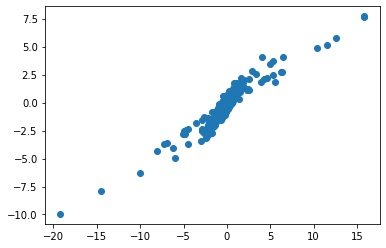

In [256]:
plt.scatter(np.squeeze(model.predict(data_gen)), data_gen_df[30:])
# spx.max()

In [240]:
pd.DataFrame(np.vstack([np.squeeze(model.predict(data_gen)), spx[30:]])).T

,0,1
0,-0.388946,-0.003588
1,0.633396,0.008036
2,0.675272,0.008818
3,0.008813,0.000725
4,0.059887,0.001275
...,...,...
1224,0.049352,0.002710
1225,0.194991,0.002303
1226,0.026615,-0.004404
1227,0.187227,0.003159


In [36]:
import tensorflow as tf
tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]